<a href="https://colab.research.google.com/github/britaniatorsulu/202055202084-Wastitorsulu/blob/master/DL_Klasifikasi_Jenis_Jam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wastibritaniatorsulu","key":"86989beda3c96851907a8f91ea830d02"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 76 May  7 03:04 kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d wastibritaniatorsulu/deep-learning-klasifikasi-jenis-jam

 96% 366M/383M [00:02<00:00, 238MB/s]
100% 383M/383M [00:02<00:00, 187MB/s]


In [10]:
!unzip deep-learning-klasifikasi-jenis-jam.zip

Archive:  deep-learning-klasifikasi-jenis-jam.zip
  inflating: Jenis Jam/Jam Dinding/0.jpg  
  inflating: Jenis Jam/Jam Dinding/1.jpg  
  inflating: Jenis Jam/Jam Dinding/10.jpg  
  inflating: Jenis Jam/Jam Dinding/100.jpg  
  inflating: Jenis Jam/Jam Dinding/101.jpg  
  inflating: Jenis Jam/Jam Dinding/102.jpg  
  inflating: Jenis Jam/Jam Dinding/103.jpg  
  inflating: Jenis Jam/Jam Dinding/104.jpg  
  inflating: Jenis Jam/Jam Dinding/105.jpg  
  inflating: Jenis Jam/Jam Dinding/106.jpg  
  inflating: Jenis Jam/Jam Dinding/107.jpg  
  inflating: Jenis Jam/Jam Dinding/108.jpg  
  inflating: Jenis Jam/Jam Dinding/109.jpg  
  inflating: Jenis Jam/Jam Dinding/11.jpg  
  inflating: Jenis Jam/Jam Dinding/110.jpg  
  inflating: Jenis Jam/Jam Dinding/111.jpg  
  inflating: Jenis Jam/Jam Dinding/112.jpg  
  inflating: Jenis Jam/Jam Dinding/113.png  
  inflating: Jenis Jam/Jam Dinding/114.jpg  
  inflating: Jenis Jam/Jam Dinding/115.jpg  
  inflating: Jenis Jam/Jam Dinding/116.jpg  
  inflating

In [11]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [12]:
dataset_path = Path(r'/content/Jenis Jam')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [13]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/Jenis Jam/Jam Pasir/102.jpg,Jam Pasir
1,/content/Jenis Jam/Jam Pasir/64.jpg,Jam Pasir
2,/content/Jenis Jam/Jam Pasir/25.jpg,Jam Pasir
3,/content/Jenis Jam/Jam Pasir/56.jpg,Jam Pasir
4,/content/Jenis Jam/Jam Pasir/130.jpg,Jam Pasir


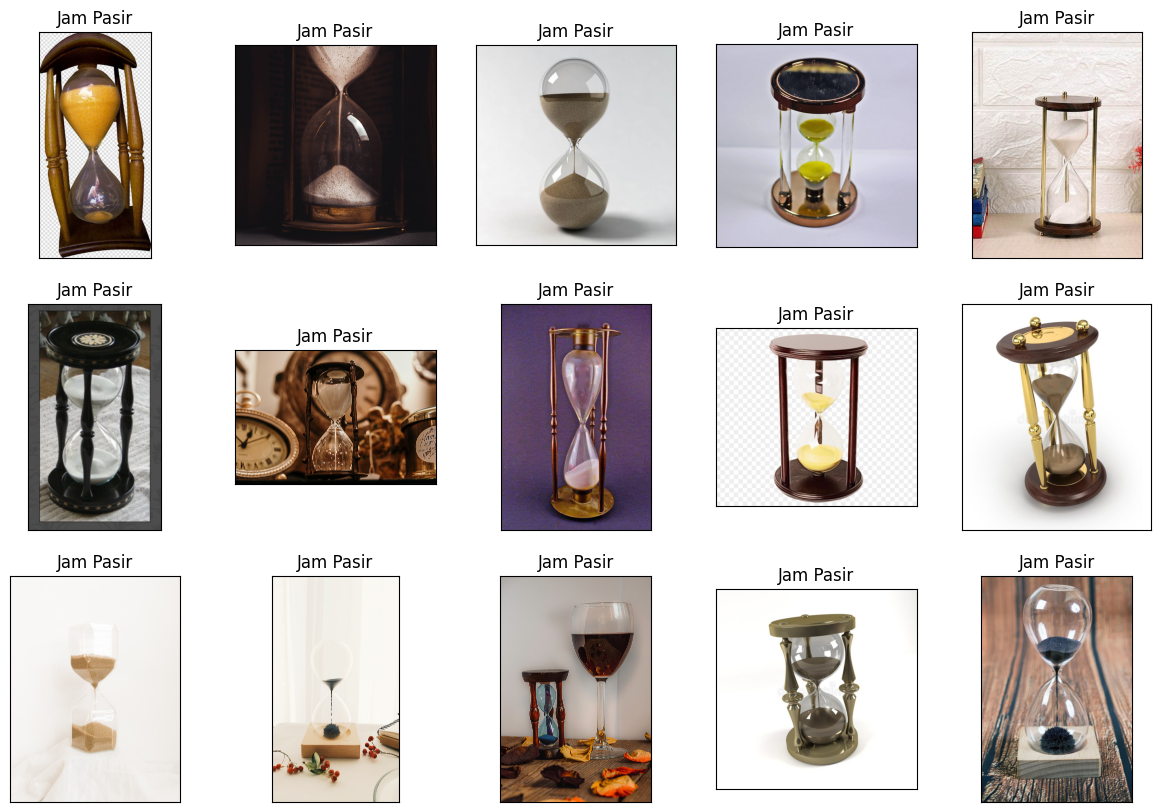

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [15]:
df.label.value_counts()

Jam Dinding    138
Jam tangan     110
Jam Pasir      107
Name: label, dtype: int64

In [16]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Jam Dinding    138
Jam tangan     110
Jam Pasir      107
Name: label, dtype: int64

In [17]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [18]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (198, 2)
Shape of test data (107, 2)
Shape of validation data (50, 2)


In [19]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 198 validated image filenames belonging to 3 classes.
Found 107 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [20]:
input_shape = (200, 200, 3)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [53]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 50, validation_data=val, epochs=150, callbacks=callback)

Epoch 1/150
7/7 [==============================] - 52s 7s/step - loss: 0.7496 - accuracy: 0.6465 - val_loss: 0.7932 - val_accuracy: 0.6600
Epoch 2/150
7/7 [==============================] - 43s 6s/step - loss: 0.7240 - accuracy: 0.6869 - val_loss: 0.9473 - val_accuracy: 0.6600
Epoch 3/150
7/7 [==============================] - 44s 6s/step - loss: 0.6582 - accuracy: 0.7172 - val_loss: 0.7110 - val_accuracy: 0.6800
Epoch 4/150
7/7 [==============================] - 44s 6s/step - loss: 0.5898 - accuracy: 0.7626 - val_loss: 0.7928 - val_accuracy: 0.6800
Epoch 5/150
7/7 [==============================] - 43s 6s/step - loss: 0.4689 - accuracy: 0.8131 - val_loss: 0.7710 - val_accuracy: 0.6800
Epoch 6/150
7/7 [==============================] - 44s 7s/step - loss: 0.4832 - accuracy: 0.7980 - val_loss: 0.6635 - val_accuracy: 0.7800
Epoch 7/150
7/7 [==============================] - 44s 7s/step - loss: 0.5524 - accuracy: 0.7828 - val_loss: 0.7019 - val_accuracy: 0.7000
Epoch 8/150
7/7 [==========

In [54]:
model.save('model-1.h5')

In [55]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

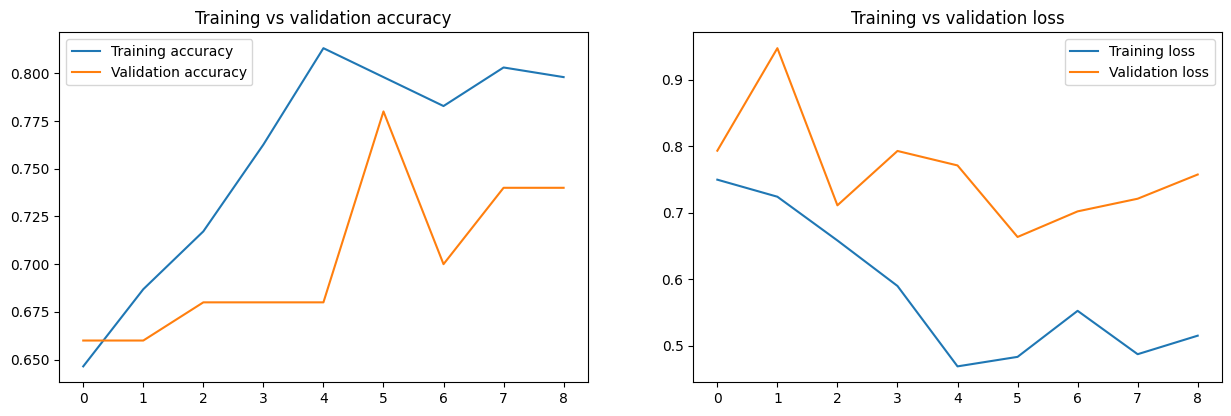

In [56]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [57]:
pred = model.predict(test)

4/4 [==============================] - 15s 4s/step


In [58]:
pred = np.argmax(pred, axis=1)

In [59]:
labels = train.class_indices

In [60]:
labels

{'Jam Dinding': 0, 'Jam Pasir': 1, 'Jam tangan': 2}

In [61]:
labels = dict((v,k) for k, v in labels.items())

In [62]:
labels

{0: 'Jam Dinding', 1: 'Jam Pasir', 2: 'Jam tangan'}

In [63]:
y_pred = [labels[k] for k in pred]

In [64]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

 Jam Dinding       0.78      0.39      0.52        46
   Jam Pasir       0.63      0.83      0.72        35
  Jam tangan       0.50      0.73      0.59        26

    accuracy                           0.62       107
   macro avg       0.64      0.65      0.61       107
weighted avg       0.66      0.62      0.60       107



In [65]:
print(confusion_matrix(x_test.label, y_pred))

[[18 13 15]
 [ 2 29  4]
 [ 3  4 19]]


In [66]:
test_accuracy = model.evaluate(test)[1]

4/4 [==============================] - 18s 5s/step - loss: 0.9727 - accuracy: 0.6262
